# General variables and libraries
Run this cell first

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from itertools import combinations
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
from statannot import add_stat_annotation
import colorcet as cc
import matplotlib.patches as mpatches
from collections import Counter

%matplotlib inline

sns.set_style("ticks")
plt.rcParams['axes.linewidth'] = .8 #adjust line width
plt.rcParams['figure.dpi'] = 200 #dpi in notebook
plt.rcParams['savefig.dpi'] = 600 #dpi in saved figure

#VARIABLES
BIG = '/home/meco/Big_data/RUSITEC/SqueezeMeta'
TABS = 'Data/FTables/'
META = pd.read_csv('metadata.tsv', sep='\t', index_col=0)
MModTabs = 'Data/Methane_modules'

FUNCS = {
    'KO': 'KO',
    #'COG': 'COG',
    #'CAZyDB': 'CAZy'
}

STYPES = {
    'RSP': 'RSP', 
    'RF': 'RF', 
    'FL': 'Fermenter liquid', 
    'FR': 'Feed residue'}

BETAS = {
    #'aitchison': 'Aitchison', 
    'bray_curtis': 'Bray-Curtis'}

MDICT = {
    'RF': 'd', 
    'RSP': 's', 
    #'E': '^', 
    'FL': 'p', 
    'FR': 'X'}

CDICT = {
    'TMR': 'grey',
    'AN1': 'limegreen',
    'AN2': 'green',
    'AT': 'red',
    'FV1': 'deepskyblue',
    'FV2': 'blue',
    'NoT': 'whitesmoke'}

Methane_Modules = {
    'Methanogenesis': {
        'M00567': 'CO2 => methane',
        'M00357': 'acetate => methane',
        'M00356': 'methanol => methane',
        'M00563': 'di/tri/methylamine => methane'},
    'Formaldehyde assimilation': {
        'M00346': 'serine pathway',
        'M00345': 'ribulose monophosphate pathway',
        'M00344': 'xylulose monophosphate pathway'},
    'Methanogenesis related': {
        'M00358': 'Coenzyme M biosynthesis',
        'M00608': '2-Oxocarboxylic acid chain extension',
        'M00174': 'Methane oxidation, methanotroph, methane => formaldehyde',
        'M00378': 'F420 biosynthesis, archaea',
        'M00935': 'Methanofuran biosynthesis',
        'M00422': 'Acetyl-CoA pathway'}}

KO_TABS = {
    'KO': 'KO (Metabolism)',
    'KO_methane': 'KO (Methane metabolism)',
    'PWY': 'KO Pathways'}

!mkdir -p $TABS $MMod Results/FCore-metrics

# Qiime2
## Import KOs

In [17]:
for fn in FUNCS:
    raw = pd.DataFrame()
    for bs in STYPES:
        df = pd.read_csv(f'{BIG}/{bs}_SM_CAZy_archive/ext_tables/Tables_no_uncl/' + 
                         f'{bs}_SqueezeMeta_CAZy.{fn}.abund.tsv', sep='\t')
        df = df.rename({'Unnamed: 0': 'ID',}, axis=1)       
        df = df.groupby(['ID']).sum()
        raw = pd.concat([raw, df], axis=1)
    raw = raw.fillna(0)
    raw = raw.drop(['Unclassified', 'Unmapped'], axis=0)
    raw.columns = raw.columns.str.replace('sample', 's')
    raw.to_csv(f'{TABS}/{fn}_raw_abundance.tsv', sep='\t')

In [4]:
# Function that will perform DESeq2-like transformation on dataframe
# Features as rows and samples as columns 
def deseq2_norm(df):
    norm = (df.apply(np.log))                              # take a log of df
    norm['mean'] = norm.mean(numeric_only=True, axis=1)    # mean as pseudoreference
    norm = norm.loc[~norm['mean'].isin([np.inf, -np.inf])] # get rid of '-inf'
    norm = norm[norm.columns] - norm[['mean']].values      # substract mean
    norm = norm.drop('mean',axis=1)                        # drop mean
    medians = norm.median()                                # median values by samples
    factors = np.exp(medians)                              # convert to expotentials
    df = df/factors                                        # divide original counts by scaling factors
    return(df)


for fn in FUNCS:
    data = pd.read_csv(f'{TABS}/{fn}_raw_abundance.tsv', sep='\t', index_col=0)
    data = deseq2_norm(data).round(0).astype(int) #deseq2 norm and round to 0
    file = f'{TABS}/{fn}_table.tsv'
    biom = f'{TABS}/{fn}_table.biom'
    artf = f'{TABS}/{fn}_table.qza'
    vizn = f'{TABS}/{fn}_table.qzv'
    data.to_csv(file, sep='\t')

    #convert to biom and import
    !biom convert -i $file -o $biom --table-type="OTU table" --to-hdf5

    !qiime tools import \
        --input-path $biom \
        --type 'FeatureTable[Frequency]' \
        --input-format BIOMV210Format \
        --output-path $artf

    !rm $biom

    #summarize
    !qiime feature-table summarize \
        --i-table $artf \
        --m-sample-metadata-file metadata.tsv \
        --o-visualization $vizn

Imported Data/FTables//KO_table.biom as BIOMV210Format to Data/FTables//KO_table.qza
Saved Visualization to: Data/FTables//KO_table.qzv


In [5]:
# Create taxonomy file
for fn in FUNCS:
    data = pd.read_csv(f'{TABS}/{fn}_table.tsv', sep='\t', index_col=0)
    taxa = pd.DataFrame()
    TAXA = f'Data/{fn}-taxonomy.qza'
    
    #merge KO names from projects
    for bs in STYPES:
        names = pd.read_csv(f'{BIG}/{bs}_SM_CAZy_archive/ext_tables/Tables_no_uncl/' + 
                         f'{bs}_SqueezeMeta_CAZy.{fn}.names.tsv', sep='\t', index_col=0)
        taxa = pd.concat([taxa, names])
    taxa = taxa[~taxa.index.duplicated(keep='first')]
    
    #most common pathway levels
    levs = ['Lev1','Lev2','Lev3']
    taxa.loc[~taxa.Path.str.contains(';'), levs] = ['Unclassified']*3
    for i, l in enumerate(levs):
        taxa[l] = taxa.loc[taxa[l] != 'Unclassified']['Path']\
                  .map(lambda a: Counter([x.split('; ')[i] for x in a.split(' | ')]).most_common()[0][0])
    taxa.loc[~taxa.Path.str.contains(';'), levs] = ['Unclassified']*3
    
    taxa.index.name = 'Feature ID'
    taxa['Taxon'] = taxa.Lev1 +';'+ taxa.Lev2 +';'+ taxa.Lev3 +';'\
                    + taxa.index +' '+ taxa.Name.str.split('[').str[0]
    taxa = taxa[['Taxon']]
    taxa.to_csv(f'Data/{fn}-taxonomy.tsv',sep='\t')
    
    #import to qiime2
    !qiime tools import \
        --type 'FeatureData[Taxonomy]' \
        --input-path Data/$fn-taxonomy.tsv \
        --output-path $TAXA

Imported Data/KO-taxonomy.tsv as TSVTaxonomyDirectoryFormat to Data/KO-taxonomy.qza


In [6]:
#drop some keggs
drop = ['Aging', 'Cancers', 'Organismal', 'Development', 'Digestive', 'Endocrine', 'Drug', 
        'Excretory', 'Immune', 'diseases', 'Nervous', 'Unclassified', 'Sensory', 'Poorly']

pattern = ','.join(drop)

for fn in FUNCS:
    table = f'{TABS}/{fn}_table.qza'
    tabvz = f'{TABS}/{fn}_table.qzv'
    ttsv = f'{TABS}/{fn}_table.tsv'
    
    !qiime taxa filter-table \
        --i-table $table \
        --i-taxonomy Data/$fn-taxonomy.qza \
        --p-include 'Metabolism;' \
        --o-filtered-table $table
    
    !qiime taxa filter-table \
        --i-table $table \
        --i-taxonomy Data/$fn-taxonomy.qza \
        --p-exclude $pattern \
        --o-filtered-table $table
    
    #summarize
    !qiime feature-table summarize \
        --i-table $table \
        --m-sample-metadata-file metadata.tsv \
        --o-visualization $tabvz
    
    #export filtered tables
    !qiime tools export \
        --input-path $table \
        --output-path $TABS
    
    !biom convert -i $TABS/feature-table.biom -o $ttsv --to-tsv
    
    !rm -rf $TABS/feature-table.biom
    
    df = pd.read_csv(ttsv, sep='\t', index_col=0, skiprows=1)
    df.to_csv(ttsv, sep='\t')

Saved FeatureTable[Frequency] to: Data/FTables//KO_table.qza
Saved FeatureTable[Frequency] to: Data/FTables//KO_table.qza
Saved Visualization to: Data/FTables//KO_table.qzv
Exported Data/FTables//KO_table.qza as BIOMV210DirFmt to directory Data/FTables/


In [7]:
pattern

'Aging,Cancers,Organismal Systems,Development,Digestive,Endocrine,Drug resistance,Excretory,Immune,diseases,Nervous,Unclassified,Sensory system,Poorly'

## Methane metabolism

In [22]:
#Retrieve KOs and reactions for methane metabolism
for mcat in Methane_Modules:
    for m in Methane_Modules[mcat]:
        df = pd.read_html(f'https://www.kegg.jp/kegg-bin/view_ortholog_table?md={m}')[0]
        df.to_csv(f'{MModTabs}/{m}_source.tsv', sep='\t')

In [7]:
#Retrieve KOs and reactions for methane metabolism
meth_KO = pd.DataFrame(columns=['KO', 'Gene', 'Category', 'Module'])
for mcat in Methane_Modules:
    for m in Methane_Modules[mcat]:
        df = pd.read_csv(f'{MModTabs}/{m}_source.tsv', sep='\t', skiprows=1, index_col=0)
        df = df[[c for c in df.columns if c.startswith('K')]]
        kos = pd.DataFrame()
        kos['KO'] = [c.split('(')[0] for c in df.columns]
        kos['Gene'] = [c.split('(')[1].split(')')[0] for c in df.columns]
        kos[['Category', 'Module']] = [mcat, f'{m}: {Methane_Modules[mcat][m]}']
        meth_KO = pd.concat([meth_KO, kos], ignore_index=True)
        #display(kos)
meth_KO.to_csv(f'{MModTabs}/Methane_metabolism_KOs.tsv', sep='\t')
data = pd.read_csv(f'{TABS}/{fn}_table.tsv', sep='\t', index_col=0)
data = data.loc[data.index.isin(meth_KO['KO'])]

file = f'{TABS}/{fn}_methane_table.tsv'
biom = f'{TABS}/{fn}_methane_table.biom'
artf = f'{TABS}/{fn}_methane_table.qza'
vizn = f'{TABS}/{fn}_methane_table.qzv'
data.to_csv(file, sep='\t')

#convert to biom and import
!biom convert -i $file -o $biom --table-type="OTU table" --to-hdf5

!qiime tools import \
    --input-path $biom \
    --type 'FeatureTable[Frequency]' \
    --input-format BIOMV210Format \
    --output-path $artf

!rm $biom

#summarize
!qiime feature-table summarize \
    --i-table $artf \
    --m-sample-metadata-file metadata.tsv \
    --o-visualization $vizn

Imported Data/FTables//KO_methane_table.biom as BIOMV210Format to Data/FTables//KO_methane_table.qza
Saved Visualization to: Data/FTables//KO_methane_table.qzv


# Core-metrics

In [8]:
def find_depth(qzv):  
    a = !unzip $qzv
    out = a[1].split('/')[0].replace('  inflating: ', '')
    dfs = pd.read_csv(f'{out}/data/sample-frequency-detail.csv', index_col=0)
    !rm -rf $out
    return int(dfs.min().min())


for ko in KO_TABS:
    if ko == 'PWY':
        continue
    COREM = f'Results/FCore-metrics/{ko}'
    TABLE = f'{TABS}/{ko}_table.qza'
    tablv = f'{TABS}/{ko}_table.qzv'
    depth = find_depth(tablv)

    !qiime diversity core-metrics \
        --i-table $TABLE \
        --p-sampling-depth $depth \
        --m-metadata-file metadata.tsv \
        --p-n-jobs 'auto' \
        --output-dir $COREM

Saved FeatureTable[Frequency] to: Results/FCore-metrics/KO/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: Results/FCore-metrics/KO/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Results/FCore-metrics/KO/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: Results/FCore-metrics/KO/evenness_vector.qza
Saved DistanceMatrix to: Results/FCore-metrics/KO/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Results/FCore-metrics/KO/bray_curtis_distance_matrix.qza
Saved PCoAResults to: Results/FCore-metrics/KO/jaccard_pcoa_results.qza
Saved PCoAResults to: Results/FCore-metrics/KO/bray_curtis_pcoa_results.qza
Saved Visualization to: Results/FCore-metrics/KO/jaccard_emperor.qzv
Saved Visualization to: Results/FCore-metrics/KO/bray_curtis_emperor.qzv
Saved FeatureTable[Frequency] to: Results/FCore-metrics/KO_methane/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: Results/FCore-metrics/KO_methane/observed_features_vector.qza
Saved SampleData[AlphaDiversity] 

### Filter Bray-Curtis Distances

In [9]:
def filter_matrix(distin, mdf, distex, pcoa, plot):
    #filter
    !qiime diversity filter-distance-matrix \
        --i-distance-matrix $distin \
        --m-metadata-file $mdf \
        --o-filtered-distance-matrix $distex
    #pcoa
    !qiime diversity pcoa \
        --i-distance-matrix $distex \
        --o-pcoa $pcoa
    #plot
    !qiime emperor plot \
        --i-pcoa $pcoa \
        --m-metadata-file $mdf \
        --o-visualization $plot


for ko in KO_TABS:
    if ko == 'PWY':
        continue
    COREM = f'Results/FCore-metrics/{ko}'
    for beta in BETAS:
        
        # Filter by stype:
        for st in STYPES:
            md = META.loc[META.BS == st].copy()
            distin = f'{COREM}/{beta}_distance_matrix.qza'
            distex = f'{COREM}/{st}_{beta}_distance_matrix.qza'
            pcoa = f'{COREM}/{st}_{beta}_pcoa_results.qza'
            plot = f'{COREM}/{st}_{beta}_emperor.qzv'
            mdf = f'Data/{st}-metadata.tsv'
            md.to_csv(mdf, sep='\t')
            filter_matrix(distin, mdf, distex, pcoa, plot)

Saved DistanceMatrix to: Results/FCore-metrics/KO/RSP_bray_curtis_distance_matrix.qza
Saved PCoAResults to: Results/FCore-metrics/KO/RSP_bray_curtis_pcoa_results.qza
Saved Visualization to: Results/FCore-metrics/KO/RSP_bray_curtis_emperor.qzv
Saved DistanceMatrix to: Results/FCore-metrics/KO/RF_bray_curtis_distance_matrix.qza
Saved PCoAResults to: Results/FCore-metrics/KO/RF_bray_curtis_pcoa_results.qza
Saved Visualization to: Results/FCore-metrics/KO/RF_bray_curtis_emperor.qzv
Saved DistanceMatrix to: Results/FCore-metrics/KO/FL_bray_curtis_distance_matrix.qza
Saved PCoAResults to: Results/FCore-metrics/KO/FL_bray_curtis_pcoa_results.qza
Saved Visualization to: Results/FCore-metrics/KO/FL_bray_curtis_emperor.qzv
Saved DistanceMatrix to: Results/FCore-metrics/KO/FR_bray_curtis_distance_matrix.qza
Saved PCoAResults to: Results/FCore-metrics/KO/FR_bray_curtis_pcoa_results.qza
Saved Visualization to: Results/FCore-metrics/KO/FR_bray_curtis_emperor.qzv
Saved DistanceMatrix to: Results/FCor

## Beta diversity

### Import libraries, declare common variables

In [10]:
#function to unzip matrix
def get_matrix(qza):
    a = !unzip $qza
    out = a[1].split('/')[0].replace('  inflating: ','')
    inf = out + '/data/distance-matrix.tsv'
    matrix = pd.read_csv(inf,index_col=0,sep='\t')
    !rm -rf $out
    return matrix

#function to modify adonis-strata output
def process_res(path, mode):
    resdf = pd.read_csv(path, sep='\t',)
    resdf[['Formula', 'Mode']] = [formula, mode]
    return resdf.loc[[i for i in resdf.index if i not in ['Residuals', 'Total']]]

#function to run adonis with strata
def run_adonis_strata(qza, formula, strata=None, perms=999, t=4, pairwise=False):
    out = 'temp'
    
    !mkdir -p $out
    
    matrix = get_matrix(qza)
    md = META.loc[matrix.columns].copy()
    matrix.to_csv(f'{out}/matrix.tsv', sep='\t')        
    md.to_csv(f'{out}/md.tsv', sep='\t')
    adonisR = '/home/*/Dropbox/TY_scripts/run_adonis.R'
    columns = ['Df', 'SumsOfSqs', 'MeanSqs', 'F.Model', 'R2', 'Pr(>F)',\
               'Formula', 'Mode', 'Group1', 'Group2', 'p', 'q']
    summary = pd.DataFrame(columns = columns)
    com = f'{adonisR} {out}/matrix.tsv {out}/md.tsv {formula} {perms} {t} {strata} {out}/res.tsv'
                
    a = !$com

    resdf = process_res(f'{out}/res.tsv', 'General')
    summary = pd.concat([summary, resdf]) 
    
    if pairwise:
        for ind in pairwise:
            if resdf.loc[ind, 'Pr(>F)'] > .05: 
                continue
            subsum = pd.DataFrame(columns = columns)
            for pair in combinations(md[ind].unique(), 2):
                submd = md.loc[md[ind].isin(pair)]
                submx = matrix.loc[submd.index, submd.index].copy()
                submx.to_csv(f'{out}/mx-pairs.tsv', sep='\t')        
                submd.to_csv(f'{out}/md-pairs.tsv', sep='\t') 
                com = f'{adonisR} {out}/mx-pairs.tsv {out}/md-pairs.tsv {formula} {perms} {t} {strata} {out}/res-pairs.tsv'
                
                a = !$com
                
                subres = process_res(f'{out}/res-pairs.tsv', 'Pairwise')
                subres[['Group1', 'Group2']] = pair
                subsum = pd.concat([subsum, subres])
            subsum['p'] = subsum['Pr(>F)']
            subsum['Pr(>F)'] = None
            subsum['q'] = multipletests(subsum['p'], method='fdr_bh')[1]
            subsum = subsum.loc[[ind], :].copy()
            summary = pd.concat([summary, subsum])

    !rm -r $out
    
    summary.index.name = 'Factor'
    return summary


adonis_out = 'Results/FAdonis'

!mkdir -p $adonis_out

### Adonis (multi-way PERMANOVA)

In [11]:
# Test effect of the BS and Treatment
for ko in KO_TABS:
    if ko == 'PWY':
        continue
    COREM = f'Results/FCore-metrics/{ko}'
    summary = pd.DataFrame()
    for beta in BETAS:
        for st in STYPES:
            if st in ['RSP', 'RF']:
                continue
            qza = f'{COREM}/{st}_{beta}_distance_matrix.qza'
            formula = "'Trt + rstc_run'"
            pairs = ['Trt']
            summ = run_adonis_strata(qza, formula, pairwise=pairs, strata='rstc_run')
            summ['sType'] = st
            summ['Metric'] = beta
            summary = pd.concat([summary, summ])
    summary.to_csv(f'{adonis_out}/{ko}_Trt_adonis.tsv', sep='\t')
    display(summary)

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr(>F),Formula,Mode,Group1,Group2,p,q,sType,Metric
Factor,,,,,,,,,,,,,,
Trt,5,0.046976,0.009395,2.269821,0.337937,0.008,'Trt + rstc_run',General,NaN,NaN,NaN,NaN,FL,bray_curtis
rstc_run,1,0.021666,0.021666,5.234433,0.155863,0.001,'Trt + rstc_run',General,NaN,NaN,NaN,NaN,FL,bray_curtis
Trt,1,0.001627,0.001627,0.347878,0.047371,None,'Trt + rstc_run',Pairwise,AN2,AN1,0.820,0.849310,FL,bray_curtis
Trt,1,0.002256,0.002256,0.504771,0.065669,None,'Trt + rstc_run',Pairwise,AN2,FV1,0.664,0.796800,FL,bray_curtis
Trt,1,0.002170,0.002170,0.527847,0.066976,None,'Trt + rstc_run',Pairwise,AN2,FV2,0.704,0.805556,FL,bray_curtis
Trt,1,0.020092,0.020092,4.198284,0.382110,None,'Trt + rstc_run',Pairwise,AN2,AT,0.018,0.067500,FL,bray_curtis
Trt,1,0.002316,0.002316,0.783985,0.081972,None,'Trt + rstc_run',Pairwise,AN2,TMR,0.564,0.705000,FL,bray_curtis
Trt,1,0.001733,0.001733,0.359230,0.048367,None,'Trt + rstc_run',Pairwise,AN1,FV1,0.725,0.805556,FL,bray_curtis
Trt,1,0.002466,0.002466,0.533171,0.071072,None,'Trt + rstc_run',Pairwise,AN1,FV2,0.821,0.849310,FL,bray_curtis


,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr(>F),Formula,Mode,Group1,Group2,p,q,sType,Metric
Factor,,,,,,,,,,,,,,
Trt,5,0.110060,0.022012,4.574409,0.551230,0.002,'Trt + rstc_run',General,NaN,NaN,NaN,NaN,FL,bray_curtis
rstc_run,1,0.007799,0.007799,1.620735,0.039061,0.176,'Trt + rstc_run',General,NaN,NaN,NaN,NaN,FL,bray_curtis
Trt,1,0.004211,0.004211,1.034357,0.135872,None,'Trt + rstc_run',Pairwise,AN2,AN1,0.426,0.491538,FL,bray_curtis
Trt,1,0.005458,0.005458,2.213699,0.235246,None,'Trt + rstc_run',Pairwise,AN2,TMR,0.012,0.060000,FL,bray_curtis
Trt,1,0.002388,0.002388,0.755182,0.094522,None,'Trt + rstc_run',Pairwise,AN2,FV2,0.495,0.531429,FL,bray_curtis
Trt,1,0.053733,0.053733,7.617382,0.537607,None,'Trt + rstc_run',Pairwise,AN2,AT,0.010,0.060000,FL,bray_curtis
Trt,1,0.002025,0.002025,0.524309,0.075759,None,'Trt + rstc_run',Pairwise,AN2,FV1,0.726,0.751034,FL,bray_curtis
Trt,1,0.011214,0.011214,3.643821,0.357386,None,'Trt + rstc_run',Pairwise,AN1,TMR,0.006,0.060000,FL,bray_curtis
Trt,1,0.008139,0.008139,2.027598,0.243411,None,'Trt + rstc_run',Pairwise,AN1,FV2,0.104,0.260000,FL,bray_curtis


In [12]:
# Test effect of the BS
for ko in KO_TABS:
    if ko == 'PWY':
        continue
    COREM = f'Results/FCore-metrics/{ko}'
    summary = pd.DataFrame()
    for beta in BETAS:
        qza = f'{COREM}/{beta}_distance_matrix.qza'
        formula = "'BS + rstc_run'"
        pairs = ['BS']
        summ = run_adonis_strata(qza, formula, pairwise=pairs, strata='rstc_run')
        summ['Metric'] = beta
        summary = pd.concat([summary, summ])
    summary.to_csv(f'{adonis_out}/{ko}_BS_adonis.tsv', sep='\t')
    display(summary)

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr(>F),Formula,Mode,Group1,Group2,p,q,Metric
Factor,,,,,,,,,,,,,
BS,3,0.855906,0.285302,42.005596,0.701404,0.001,'BS + rstc_run',General,NaN,NaN,NaN,NaN,bray_curtis
rstc_run,1,0.045145,0.045145,6.646858,0.036996,0.004,'BS + rstc_run',General,NaN,NaN,NaN,NaN,bray_curtis
BS,1,0.031527,0.031527,52.482174,0.944825,None,'BS + rstc_run',Pairwise,RSP,RF,0.166667,0.181818,bray_curtis
BS,1,0.077032,0.077032,14.846292,0.355889,None,'BS + rstc_run',Pairwise,RSP,FL,0.001000,0.001714,bray_curtis
BS,1,0.118162,0.118162,17.151085,0.345414,None,'BS + rstc_run',Pairwise,RSP,FR,0.001000,0.001714,bray_curtis
BS,1,0.110326,0.110326,21.123007,0.439951,None,'BS + rstc_run',Pairwise,RF,FL,0.001000,0.001714,bray_curtis
BS,1,0.173765,0.173765,25.110012,0.435811,None,'BS + rstc_run',Pairwise,RF,FR,0.001000,0.001714,bray_curtis
BS,1,0.664991,0.664991,95.355665,0.647181,None,'BS + rstc_run',Pairwise,FL,FR,0.001000,0.001714,bray_curtis


,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr(>F),Formula,Mode,Group1,Group2,p,q,Metric
Factor,,,,,,,,,,,,,
BS,3,0.755989,0.251996,34.249701,0.668871,0.001,'BS + rstc_run',General,NaN,NaN,NaN,NaN,bray_curtis
rstc_run,1,0.028449,0.028449,3.866598,0.025171,0.024,'BS + rstc_run',General,NaN,NaN,NaN,NaN,bray_curtis
BS,1,0.034847,0.034847,24.559672,0.948545,None,'BS + rstc_run',Pairwise,RSP,RF,0.333333,0.444444,bray_curtis
BS,1,0.062036,0.062036,7.405365,0.236595,None,'BS + rstc_run',Pairwise,RSP,FL,0.012000,0.020571,bray_curtis
BS,1,0.133569,0.133569,24.270103,0.435394,None,'BS + rstc_run',Pairwise,RSP,FR,0.001000,0.002000,bray_curtis
BS,1,0.106219,0.106219,12.587659,0.345688,None,'BS + rstc_run',Pairwise,RF,FL,0.001000,0.002000,bray_curtis
BS,1,0.087223,0.087223,15.626130,0.333787,None,'BS + rstc_run',Pairwise,RF,FR,0.001000,0.002000,bray_curtis
BS,1,0.605350,0.605350,79.753945,0.619147,None,'BS + rstc_run',Pairwise,FL,FR,0.001000,0.002000,bray_curtis


### Beta PCoA

In [2]:
def parse_pcoa(qza): ### Unzipping qza biplots
    a = !unzip $qza
    digest = a[1].split('/')[0].replace('  inflating: ', '')
    inf = digest + '/data/ordination.txt'
    lines = open(inf, 'r').readlines()
    Eigvals = [float(i) for i in lines[1].rstrip().split('\t')]
    Proportion = [float(i) for i in lines[4].rstrip().split('\t')]
    pca_skipr = len(open(inf,'r').read().split('Site')[0].splitlines()) + 1
    pcoa = pd.read_csv(inf, index_col=0, skiprows=pca_skipr, skipfooter=4,\
                       header=None, sep='\t', engine='python')
    !rm -rf $digest
    return  pcoa, Proportion


def sub():
    for bs in set(pca_meta.BS):
        for trt in set(pca_meta.Trt):
            c = CDICT[trt]
            m = MDICT[bs]
            s = 50
            ec = 'white'
            if bs in ['RF', 'RSP']: 
                ec = 'black'
                s = 15
            df = ordin.loc[ordin.index.isin(pca_meta.loc[((pca_meta.BS==bs) & (pca_meta.Trt==trt))].index)]
            plot = sns.scatterplot(x=x, y=y, data=df, ax=ax, color=c, marker=m, s=s, 
                                   linewidth=0.25, legend=True, edgecolor=ec)
            
#function to unzip matrix
def get_matrix(qza):
    a = !unzip $qza
    out = a[1].split('/')[0].replace('  inflating: ', '')
    inf = out + '/data/distance-matrix.tsv'
    matrix = pd.read_csv(inf, index_col=0, sep='\t')
    !rm -rf $out
    return matrix


!mkdir -p Figures/Beta

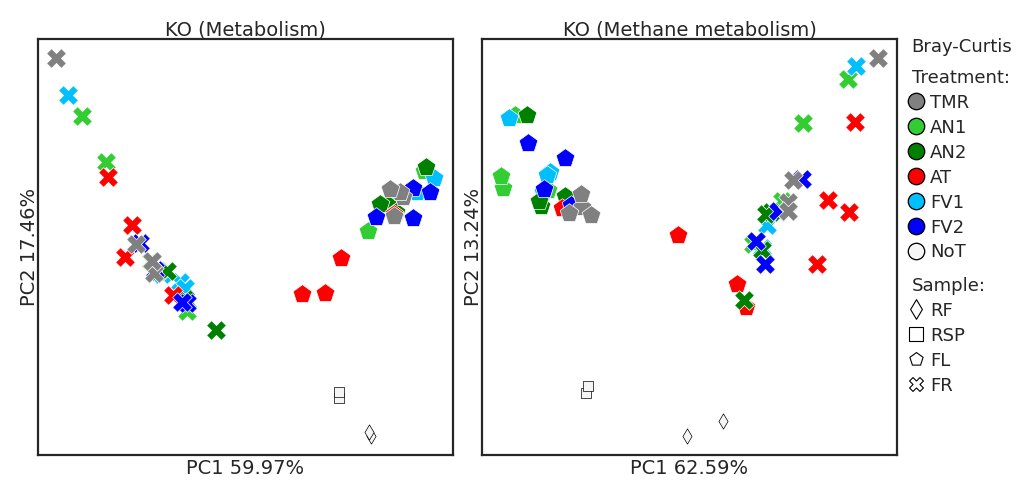

In [3]:
# Plot everything together
x, y = 1, 2 # axes to plot

for beta in BETAS:
    fig, axes = plt.subplots(1, 3, figsize=(6, 2.7), 
                             gridspec_kw={'hspace': .1, 'wspace': .1, 'width_ratios': [1,1, .1]})
    #axs, i = [[row, col] for row in range(2) for col in range(2)], 0
    for i, ko in enumerate(KO_TABS):
        if ko == 'PWY':
            continue
        COREM = f'Results/FCore-metrics/{ko}'
        ordin, Prop = parse_pcoa(f'{COREM}/{beta}_pcoa_results.qza')
        pca_meta = META.loc[META.index.isin(ordin.index)].copy()
        ax = axes[i]
        sub() #plot scatterplot by function
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel(f'PC{y:d} {Prop[y-1]*100:.2f}%', fontsize=7, labelpad=-4)
        ax.set_xlabel(f'PC{x:d} {Prop[x-1]*100:.2f}%', fontsize=7, labelpad=-2)
        ax.text(.5, 1.01, KO_TABS[ko], ha='center', fontsize=7, transform=ax.transAxes)
        
    # legend
    ax = axes[-1]
    ax.axis('off')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    yax, xax = .97, -.25
    ystep, xstep = .06, 0.35
    fsize = 6.5
    ax.text(xax -.1, yax, BETAS[beta], fontdict={'size': fsize})
    
    yax -= ystep 
    ax.text(xax -.1, yax -.015, 'Treatment:', fontdict={'size': fsize})
    for c in CDICT: #colors
        yax -= ystep
        sns.scatterplot(x=[xax], y=[yax], marker='o', color=CDICT[c], ax=ax, s=35, clip_on=False, ec='black')
        ax.text(xax + xstep, yax -.015, c, fontdict={'size': fsize})

    yax -= ystep + .02
    ax.text(xax -.1, yax -.015, 'Sample:', fontdict={'size': fsize})
    for m in MDICT: #markers
        yax -= ystep
        sns.scatterplot(x=[xax], y=[yax], marker=MDICT[m], color='white', ax=ax, 
                        s=25, clip_on=False, ec='black')
        ax.text(xax + xstep, yax -.015, m, fontdict={'size': fsize})

    plt.savefig(f'Figures/Beta/PCOA_{beta}_{ko}.png', bbox_inches='tight', facecolor='w')

In [15]:
# Melt matrix to long dataframe and add metadata
for beta in BETAS:
    for ko in KO_TABS:
        if ko == 'PWY':
            continue
        COREM = f'Results/FCore-metrics/{ko}'
        qza = f'{COREM}/{beta}_distance_matrix.qza'
        matrix = get_matrix(qza)
        longdf = matrix.melt(ignore_index=False).reset_index()
        longdf.columns = ['ID1', 'ID2', 'Distance']
        for ind in META.index:
            longdf.loc[longdf['ID1']==ind, 'ID1_Trt'] = META.loc[ind, 'Trt']
            longdf.loc[longdf['ID2']==ind, 'ID2_Trt'] = META.loc[ind, 'Trt']
            longdf.loc[longdf['ID1']==ind, 'ID1_BS'] = META.loc[ind, 'BS']
            longdf.loc[longdf['ID2']==ind, 'ID2_BS'] = META.loc[ind, 'BS']
        longdf.to_csv(f'{COREM}/{beta}_distances_melted.tsv', sep='\t', index=False)

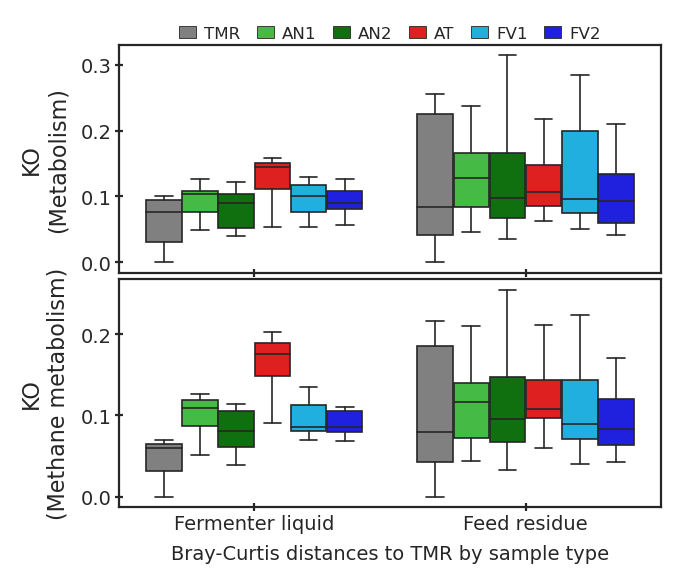

In [4]:
# Plot distances to TMR by sample type
order = ['Fermenter liquid', 'Feed residue']
horder = [k for k in CDICT.keys() if k != 'NoT']
for beta in BETAS:
    fig, axes = plt.subplots(2, 1, figsize=(3.5, 3), gridspec_kw={'hspace': .03})
    for i, ko in enumerate(KO_TABS):
        if ko == 'PWY':
            continue
        COREM = f'Results/FCore-metrics/{ko}'
        longdf = pd.read_csv(f'{COREM}/{beta}_distances_melted.tsv', sep='\t')
        df = longdf.loc[(longdf.ID2_Trt=='TMR') & (longdf.ID1_BS==longdf.ID2_BS)].copy()
        ax = axes[i]
        df['ID1_BS'] = df['ID1_BS'].map(STYPES)
        sns.boxplot(x='ID1_BS', y='Distance', hue='ID1_Trt', data=df, ax=ax, showfliers=False,
                    palette=CDICT, fliersize=1, linewidth=.6, hue_order=horder, order=order)

        #aesthetics
        ax.tick_params(axis='both', labelsize=7, length=3, pad=1, direction='inout')
        ax.set_ylabel(KO_TABS[ko].replace('KO ', 'KO\n'), fontsize=8)
        ax.set_xlabel(f'{BETAS[beta]} distances to TMR by sample type', fontsize=7)
        if ax != axes[-1]:
            ax.set_xlabel('')
        
        #legend
        ax.legend(loc=9, fontsize=6, frameon=False, bbox_to_anchor=(.5, 1.15), bbox_transform=ax.transAxes, 
                  ncol=len(CDICT), handlelength=1, handletextpad=.5, columnspacing=1)        
        if ax != axes[0]:
            ax.legend().remove()
        plt.savefig(f'Figures/Beta/Boxplot_Trts_{beta}_{ko}.png', bbox_inches='tight', facecolor='w')

In [33]:
sign_count

,BS,Function,Treatment,All_functions,Sig_functions,Sig_%,Pos_functions,Pos_%,Neg_functions,Neg_%
0,FL,KO,AN1,10354.0,18.0,0.173846,8.0,0.077265,10.0,0.096581
1,FL,KO,AN2,10354.0,15.0,0.144872,4.0,0.038632,11.0,0.106239
2,FL,KO,AT,10354.0,1978.0,19.103728,924.0,8.924087,1054.0,10.179641
3,FL,KO,FV1,10354.0,15.0,0.144872,7.0,0.067607,8.0,0.077265
4,FL,KO,FV2,10354.0,34.0,0.328376,15.0,0.144872,19.0,0.183504
5,FL,COG,AN1,36591.0,144.0,0.393539,72.0,0.196770,72.0,0.196770
6,FL,COG,AN2,36591.0,70.0,0.191304,14.0,0.038261,56.0,0.153043
7,FL,COG,AT,36591.0,5227.0,14.284933,2823.0,7.715012,2404.0,6.569922
8,FL,COG,FV1,36591.0,181.0,0.494657,92.0,0.251428,89.0,0.243229
9,FL,COG,FV2,36591.0,141.0,0.385341,49.0,0.133913,92.0,0.251428


## UpSet Plot

In [12]:
!pip install upsetplot

  Using cached UpSetPlot-0.6.0.tar.gz (17 kB)
  Created wheel for upsetplot: filename=UpSetPlot-0.6.0-py3-none-any.whl size=18093 sha256=270d245e906ee2e11d71887981ac23cbfe582193476856dc784663d88f493cfc
  Stored in directory: /home/meco/.cache/pip/wheels/10/3f/a8/e8dbf042b2f79d8a4848efca302bd39f24885cd1c62f271012
Successfully built upsetplot


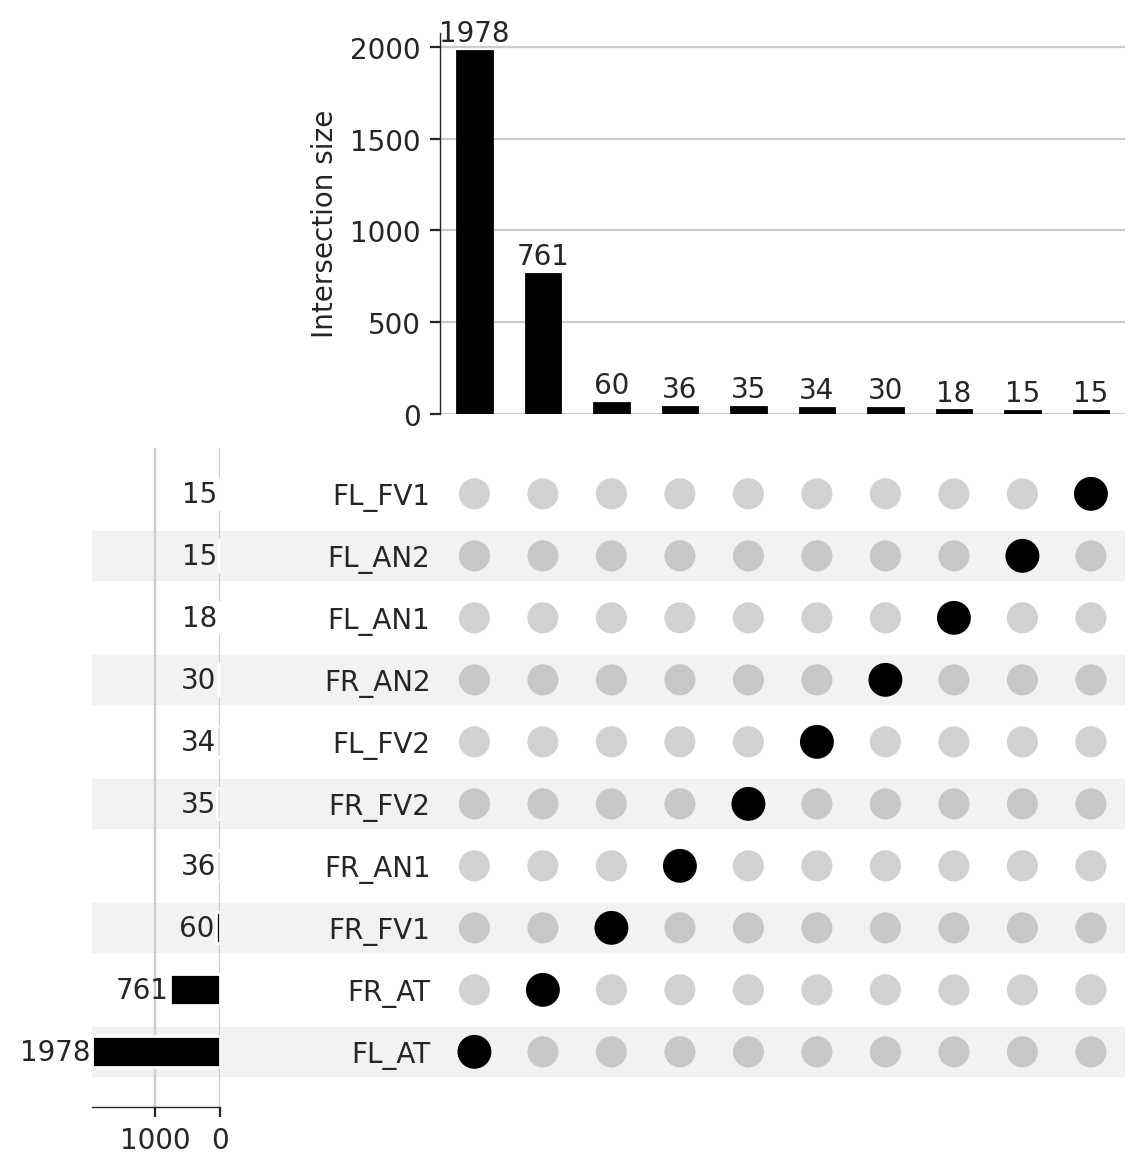

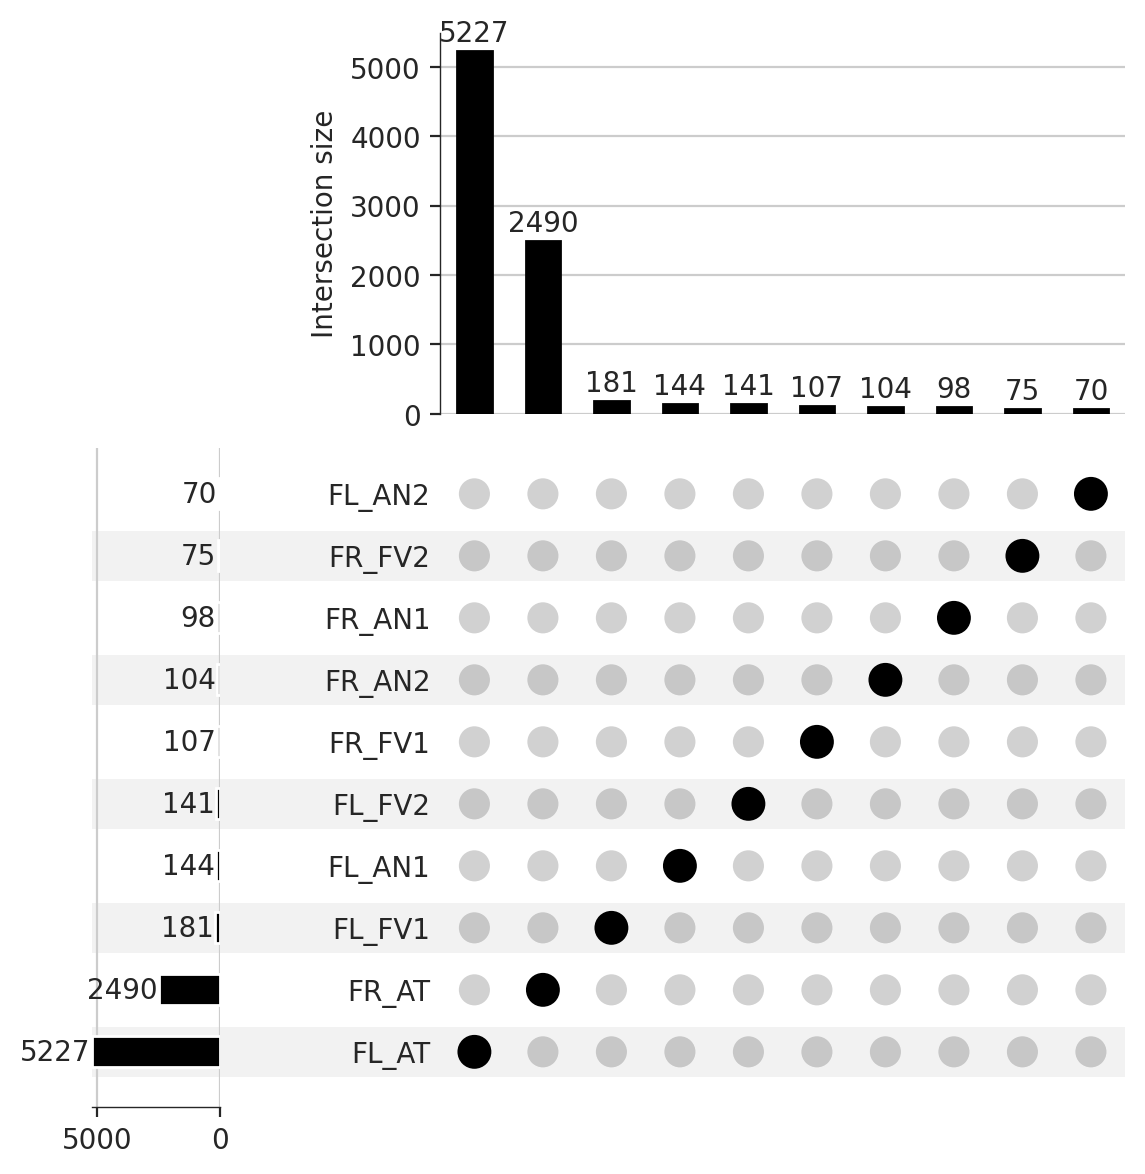

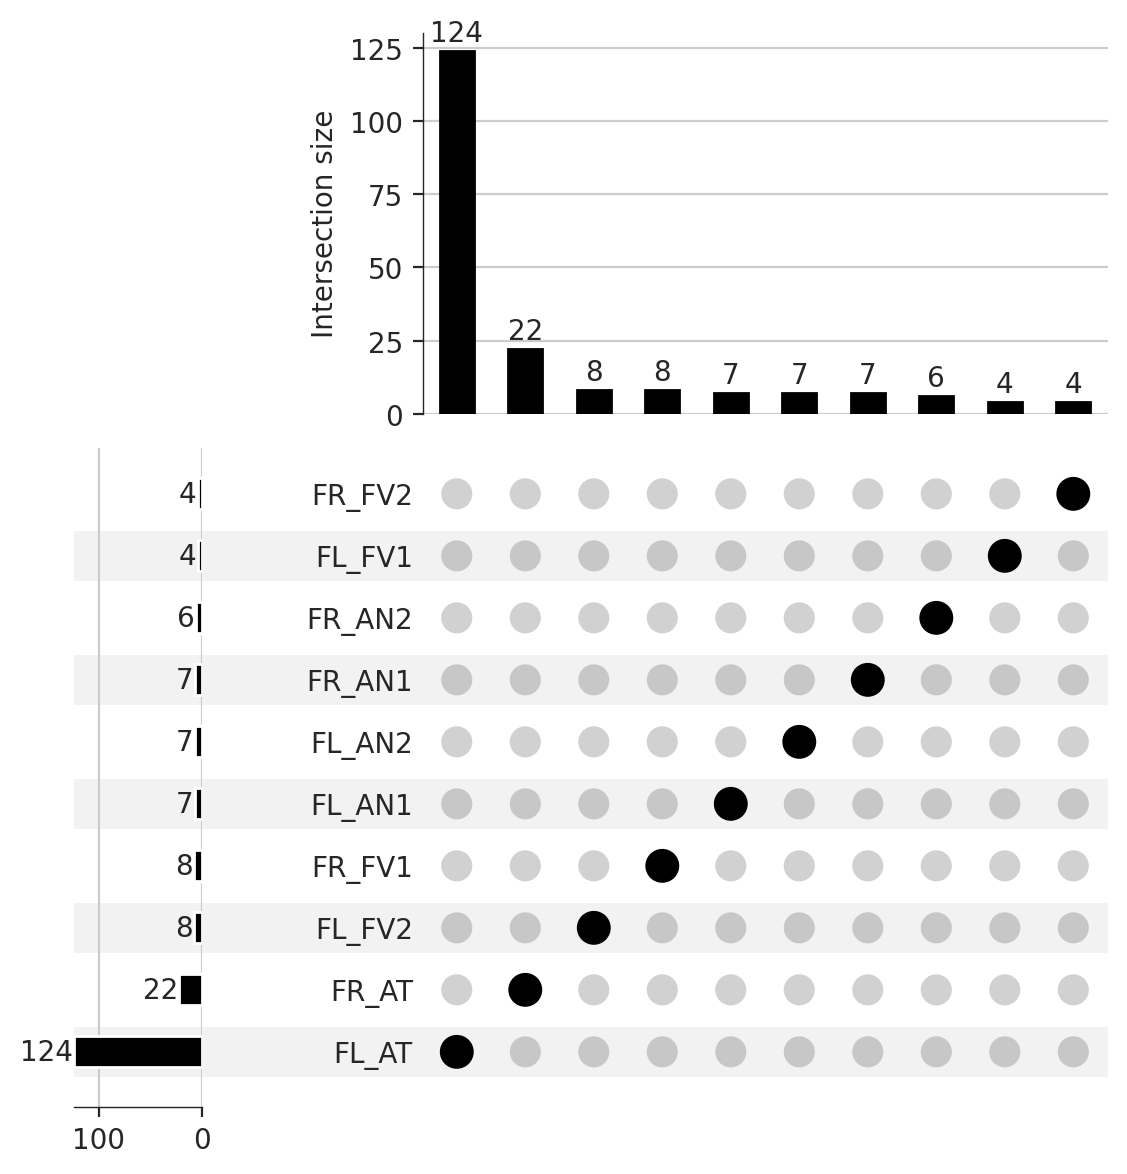

In [13]:
import upsetplot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.linewidth'] = .5 #adjust line width
plt.rcParams['figure.dpi'] = 200 #dpi in notebook
plt.rcParams['savefig.dpi'] = 600 #dpi in saved figure

#sns.set_style("ticks")
#plt.rcParams['axes.linewidth'] = .5 #adjust line width

func = ['KO','COG','CAZyDB']
meta = pd.read_csv('metadata.tsv',sep='\t',index_col=0)
bss = {'FL':'Fermenter liquid','FR':'Feed residue'}
names = {'Trt1':'TMR','Trt2':'AN1','Trt3':'AN2','Trt4':'AT','Trt5':'FV1','Trt6':'FV2'}
mdict = {'rstc_run1':'X', 'rstc_run2':'P'}
markers = {'KO':'h','COG':'P','CAZyDB':'X'}
mnames = {'KO':'KEGG','COG':'COG','CAZyDB':'CAZy'}
summary = pd.read_csv('Results/DESeq2/DESeq2.tsv',sep='\t',index_col=0)

!mkdir -p Figures/Deseq2
for fn in func:
    summ = summary.loc[(summary.Function==fn)].copy()
    sign = summ.loc[(summ.padj<=0.05)].copy()
    sign['Treatment'] = sign.Treatment.str.split('-').str[-1]
    sign['Treatment'].replace(names, inplace=True)
    sign['Treatment'] = sign['BS'] +'_'+ sign['Treatment']
    sign['ID'] = sign['BS'] +'_'+ sign['Treatment'] +'_'+ sign['ID']
    sign = sign.groupby(['ID'])['Treatment'].apply(','.join).reset_index()
    data = upsetplot.from_memberships(sign.Treatment.str.split(','), data=sign)
 #display(data)
    fig,ax = plt.subplots(1,1,figsize=(3.5,3.5))
    ax.axis('off')
    plot = upsetplot.plot(data,fig=fig,show_counts=True)
 #plot = upsetplot.UpsetPlot
    fig.savefig('Figures/Deseq2/Deseq2-UpSet-%s.png'%fn, bbox_inches='tight',facecolor="w")

# KEGGs

## Categories

In [152]:
import pandas as pd
import numpy as np
from collections import Counter

#read path names 
bss = ['RSP','RF','FL','FR']
keggs = pd.DataFrame()

for bs in bss:
    names = pd.read_csv('/home/meco/Big_data/RUSITEC/SqueezeMeta/%s_SM_CAZy_archive'%(bs)+
                    '/ext_tables/Tables/%s_SqueezeMeta_CAZy.KO.names.tsv'%(bs),sep='\t',index_col=0)
    keggs = pd.concat([keggs,names],)
keggs = keggs[~keggs.index.duplicated(keep='first')]
#most common pathway levels
levs = ['Lev1','Lev2','Lev3']
keggs.loc[~keggs.Path.str.contains(';'),levs] = ['Unclassified']*3
for i,l in enumerate(levs):
    keggs[l] = keggs.loc[keggs[l]!='Unclassified']['Path'].map(lambda a: Counter([x.split('; ')[i] for x in a.split(' | ')]).most_common()[0][0])
keggs.loc[~keggs.Path.str.contains(';'),levs] = ['Unclassified']*3
display(keggs)
keggs.to_csv('Data/KEGG-names.tsv',sep='\t')

,Name,Path,Lev1,Lev2,Lev3
K00001,alcohol dehydrogenase [EC:1.1.1.1],Metabolism; Carbohydrate metabolism; Glycolysi...,Metabolism,Xenobiotics biodegradation and metabolism,Glycolysis / Gluconeogenesis
K00002,alcohol dehydrogenase (NADP+) [EC:1.1.1.2],Metabolism; Carbohydrate metabolism; Glycolysi...,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis
K00003,homoserine dehydrogenase [EC:1.1.1.3],"Metabolism; Amino acid metabolism; Glycine, se...",Metabolism,Amino acid metabolism,"Glycine, serine and threonine metabolism"
K00004,"(R,R)-butanediol dehydrogenase / meso-butanedi...",Metabolism; Carbohydrate metabolism; Butanoate...,Metabolism,Carbohydrate metabolism,Butanoate metabolism
K00005,glycerol dehydrogenase [EC:1.1.1.6],Metabolism; Carbohydrate metabolism; Propanoat...,Metabolism,Carbohydrate metabolism,Propanoate metabolism
...,...,...,...,...,...
K22384,tail-anchored protein insertion receptor,Brite Hierarchies; Protein families: signaling...,Brite Hierarchies,Protein families: signaling and cellular proce...,Transporters
K22415,zinc finger CCCH domain-containing protein 11,Brite Hierarchies; Protein families: genetic i...,Brite Hierarchies,Protein families: genetic information processing,Messenger RNA biogenesis
K22422,protein downstream neighbor of Son,Brite Hierarchies; Protein families: genetic i...,Brite Hierarchies,Protein families: genetic information processing,DNA repair and recombination proteins
K22439,"tricetin 3',4',5'-O-trimethyltransferase [EC:2...",Not Included in Pathway or Brite; Unclassified...,Not Included in Pathway or Brite,Unclassified: metabolism,Enzymes with EC numbers


## KEGG heatmap (methane metabolism)

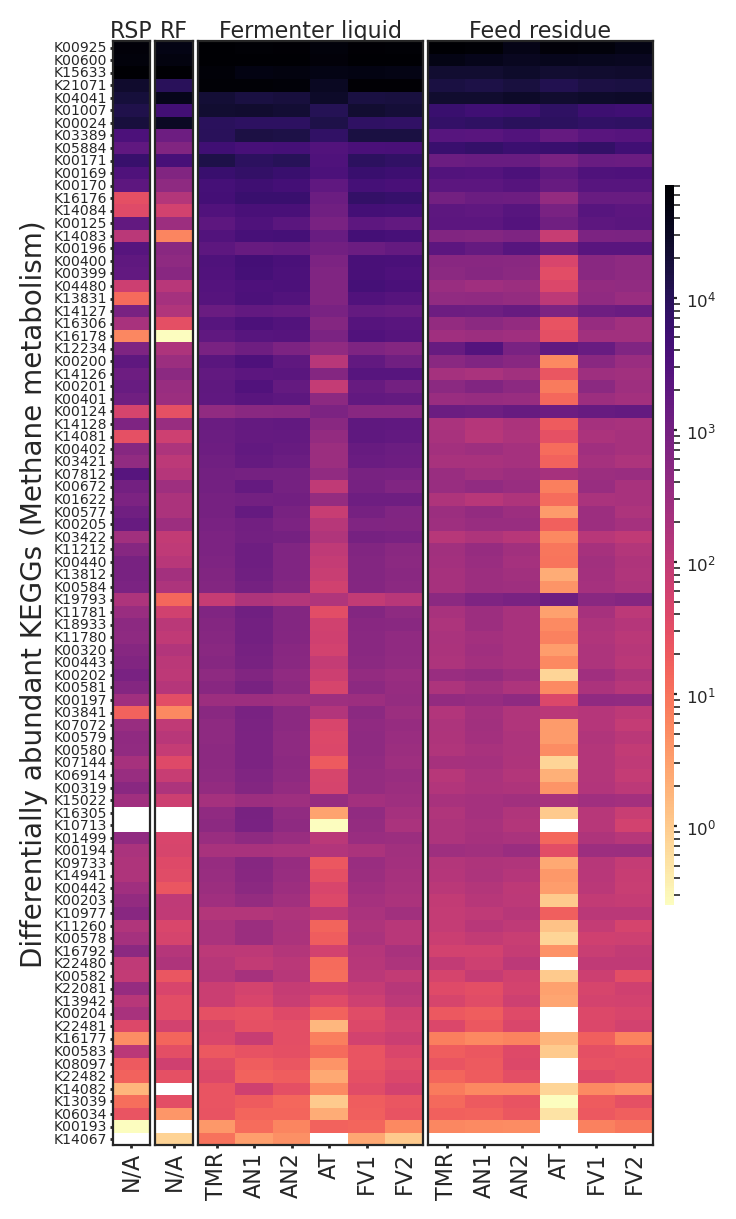

In [6]:
#import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from matplotlib.colors import LogNorm, Normalize
%matplotlib inline
plt.rcParams['axes.linewidth'] = .5 #adjust line width
plt.rcParams['figure.dpi'] = 200 #dpi in notebook
plt.rcParams['savefig.dpi'] = 600 #dpi in saved figure
sns.set_style("ticks") #set sns style

#metadata and data reading
keggs = pd.read_csv('Data/KEGG-names.tsv',sep='\t',index_col=0) #KEGG IDs, categories and letters
summary = pd.read_csv('Results/DESeq2/DESeq2.tsv',sep='\t',index_col=0) #DESeq2 summary
summ = summary.loc[(summary.Function=='KO')].copy() #only KEGGs
meta = pd.read_csv('metadata.tsv',sep='\t',index_col=0) #metadata
meta = meta.sort_values(['Treatment'],ascending=[True]) #sort metadata
meta['Sort'] = meta.rstc_run.astype(str)+'|'+meta.Treatment #create a col to sort groups
gnames = {'RSP':'RSP','RF':'RF','FL':'Fermenter liquid','FR':'Feed residue'} #groups
names = {'Trt1':'TMR','Trt2':'AN1','Trt3':'AN2','Trt4':'AT','Trt5':'FV1','Trt6':'FV2','not_appl':'N/A'}
csort = ['TMR','AN1','AN2','AT','FV1','FV2'] #sort columns

#Separate all vs TMR and AT vs TMR subsets
for sub in ['All','AT']:
    if sub == 'All': continue
    sign = summ.loc[summ.padj<=0.05].copy() #only sign KEGGs (all)
    if sub == 'AT':
        sign = sign.loc[sign.Treatment=='Trt1-Trt4'].copy() #only sign KEGGs (AT)
 #Preparing data
    data = pd.DataFrame()
    for bs in gnames:
        df = pd.read_csv('Data/Tables_fn/KO-%s-norm_table.tsv'%(bs),sep='\t',index_col=0) #KO abund.
        df.index.names = ['Function']
        data = pd.concat([data,df],axis=1) #merge all tables
    data.fillna(0, inplace=True) #fill NaNs
    data = data.loc[sign.index.unique()] #only sign. KEGGs
    data = data.assign(m=data.mean(axis=1)).sort_values('m',ascending=False).drop('m',axis=1) #sort

 #Figure and corresponding variables
    vmax,vmin = data.values.max(), data.values.min() #max and min values to plot
    w = [len(meta.loc[meta.BS==g].Treatment.unique()) for g in gnames] # subbplot width
    fig, axes = plt.subplots(1,len(w),figsize=(3,6),\
                            gridspec_kw={'hspace':.02,'wspace':.04,'width_ratios':w}) #figure
    cbar_ax = fig.add_axes([.92, .2, .015, .6]) #cbar ax
    cbar_ax.tick_params(labelsize=6,length=1)

    !mkdir -p Figures/Deseq2
    for i,g in enumerate(gnames):
 #plot by axes
        md = meta.loc[meta.BS==g].copy() #metadata
        kg = keggs.loc[keggs.Path.str.contains('Methane metabolism')].copy() #keggs associated with category
        hm = data.loc[[l for l in data.index if l in kg.index.unique()],md.index].copy().T
        
 #collapse by treatment
        hm['Treatment'] = md.Treatment
        hm['Treatment'] = hm['Treatment'].map(names)
        hm = hm.groupby('Treatment').mean().T
        if 'TMR' in hm.columns: hm = hm[csort] #sort order
                
        ax = axes[i] #ax
        sns.heatmap(data=hm,ax=ax,xticklabels=True,yticklabels=True,cbar_ax=cbar_ax,
                                vmax=vmax,vmin=vmin,cmap='magma_r',robust=True,norm=LogNorm())
 #aesthetics
        ax.tick_params(axis='both',labelsize=5,length=1,pad=1,width=1,rotation=0)
        ax.tick_params(axis='x',labelsize=8,rotation=90)
        ax.set_ylabel('Differentially abundant KEGGs (Methane metabolism)',fontsize=10,labelpad=2,)
        if g != list(gnames.keys())[0]:
            ax.axes.yaxis.set_visible(False)
            ax.set_ylabel('')
        ax.set_xlabel(gnames[g],fontsize=8,labelpad=2)
        for _, spine in ax.spines.items(): 
            spine.set_visible(True)
            spine.set_linewidth(0.8)
        ax.get_xaxis().set_label_coords(.5,1.02)
 #fig.suptitle('Differentially abundant KEGGs', fontsize=9, y=.98)
    plt.subplots_adjust(left=0, bottom=0, right=.9, top=.92, wspace=0, hspace=0)
    plt.savefig('Figures/Deseq2/KEGG_methane_heatmap_%s.png'%sub, bbox_inches='tight',facecolor="w")

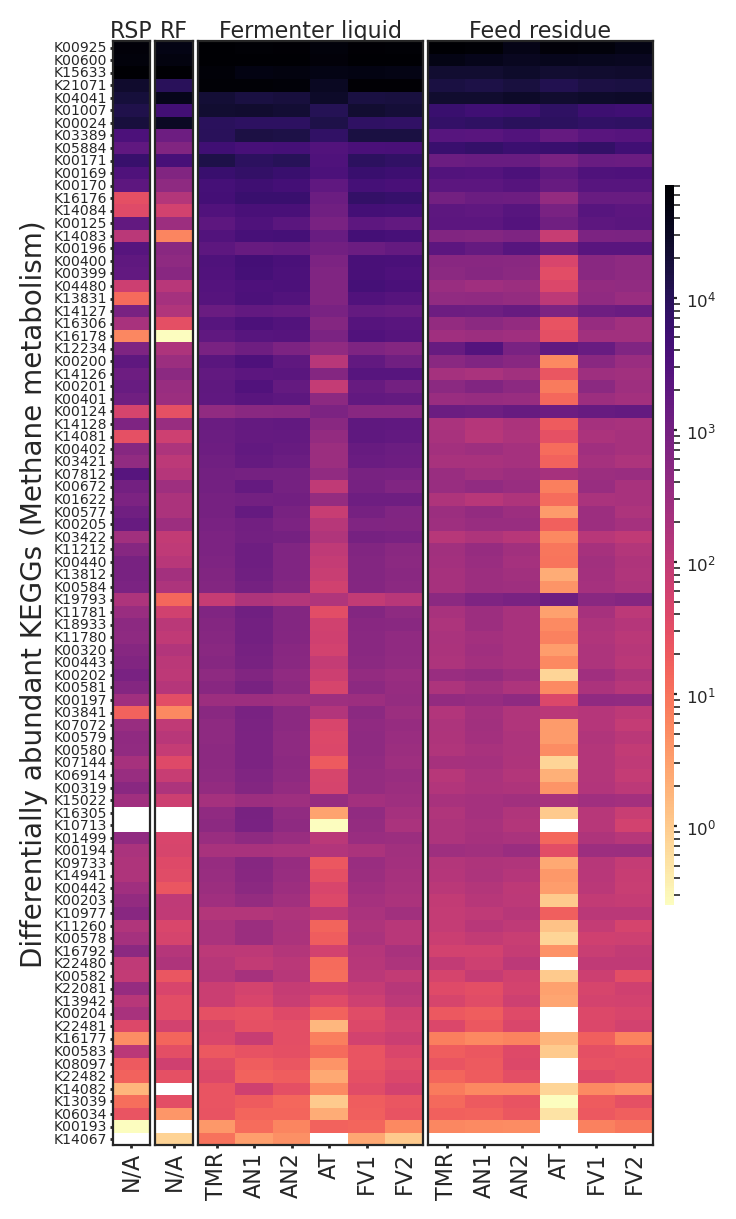

In [7]:
#Methan associated functions
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from matplotlib.colors import LogNorm, Normalize
%matplotlib inline
plt.rcParams['axes.linewidth'] = .5 #adjust line width
plt.rcParams['figure.dpi'] = 200 #dpi in notebook
plt.rcParams['savefig.dpi'] = 600 #dpi in saved figure
sns.set_style("ticks") #set sns style

#metadata and data reading
keggs = pd.read_csv('Data/KEGG-names.tsv',sep='\t',index_col=0) #KEGG IDs, categories and letters
summary = pd.read_csv('Results/DESeq2/DESeq2.tsv',sep='\t',index_col=0) #DESeq2 summary
summ = summary.loc[(summary.Function=='KO')].copy() #only KEGGs
meta = pd.read_csv('metadata.tsv',sep='\t',index_col=0) #metadata
meta = meta.sort_values(['Treatment'],ascending=[True]) #sort metadata
meta['Sort'] = meta.rstc_run.astype(str)+'|'+meta.Treatment #create a col to sort groups
gnames = {'RSP':'RSP','RF':'RF','FL':'Fermenter liquid','FR':'Feed residue'} #groups
names = {'Trt1':'TMR','Trt2':'AN1','Trt3':'AN2','Trt4':'AT','Trt5':'FV1','Trt6':'FV2','not_appl':'N/A'}
csort = ['TMR','AN1','AN2','AT','FV1','FV2'] #sort columns

#Separate all vs TMR and AT vs TMR subsets
for sub in ['All','AT']:
    if sub == 'AT': continue
    sign = summ.loc[summ.padj<=0.05].copy() #only sign KEGGs (all)
    if sub == 'AT':
        sign = sign.loc[sign.Treatment=='Trt1-Trt4'].copy() #only sign KEGGs (AT)
 #Preparing data
    data = pd.DataFrame()
    for bs in gnames:
        df = pd.read_csv('Data/Tables_fn/KO-%s-norm_table.tsv'%(bs),sep='\t',index_col=0) #KO abund.
        df.index.names = ['Function']
        data = pd.concat([data,df],axis=1) #merge all tables
    data.fillna(0, inplace=True) #fill NaNs
    data = data.loc[sign.index.unique()] #only sign. KEGGs
    data = data.assign(m=data.mean(axis=1)).sort_values('m',ascending=False).drop('m',axis=1) #sort

 #Figure and corresponding variables
    vmax,vmin = data.values.max(), data.values.min() #max and min values to plot
    w = [len(meta.loc[meta.BS==g].Treatment.unique()) for g in gnames] # subbplot width
    fig, axes = plt.subplots(1,len(w),figsize=(3,6),\
                            gridspec_kw={'hspace':.02,'wspace':.04,'width_ratios':w}) #figure
    cbar_ax = fig.add_axes([.92, .2, .015, .6]) #cbar ax
    cbar_ax.tick_params(labelsize=6,length=1)

    !mkdir -p Figures/Deseq2
    for i,g in enumerate(gnames):
 #plot by axes
        md = meta.loc[meta.BS==g].copy() #metadata
        kg = keggs.loc[keggs.Path.str.contains('Methane metabolism')].copy() #keggs associated with category
        hm = data.loc[[l for l in data.index if l in kg.index.unique()],md.index].copy().T
        
 #collapse by treatment
        hm['Treatment'] = md.Treatment
        hm['Treatment'] = hm['Treatment'].map(names)
        hm = hm.groupby('Treatment').mean().T
        if 'TMR' in hm.columns: hm = hm[csort] #sort order
                
        ax = axes[i] #ax
        sns.heatmap(data=hm,ax=ax,xticklabels=True,yticklabels=True,cbar_ax=cbar_ax,
                                vmax=vmax,vmin=vmin,cmap='magma_r',robust=True,norm=LogNorm())
 #aesthetics
        ax.tick_params(axis='both',labelsize=5,length=1,pad=1,width=1,rotation=0)
        ax.tick_params(axis='x',labelsize=8,rotation=90)
        ax.set_ylabel('Differentially abundant KEGGs (Methane metabolism)',fontsize=10,labelpad=2,)
        if g != list(gnames.keys())[0]:
            ax.axes.yaxis.set_visible(False)
            ax.set_ylabel('')
        ax.set_xlabel(gnames[g],fontsize=8,labelpad=2)
        for _, spine in ax.spines.items(): 
            spine.set_visible(True)
            spine.set_linewidth(0.8)
        ax.get_xaxis().set_label_coords(.5,1.02)
 #fig.suptitle('Differentially abundant KEGGs', fontsize=9, y=.98)
    plt.subplots_adjust(left=0, bottom=0, right=.9, top=.92, wspace=0, hspace=0)
    plt.savefig('Figures/Deseq2/KEGG_methane_heatmap_%s_all.png'%sub, bbox_inches='tight',facecolor="w")

## KEGG heatmap (all significant collapsed)

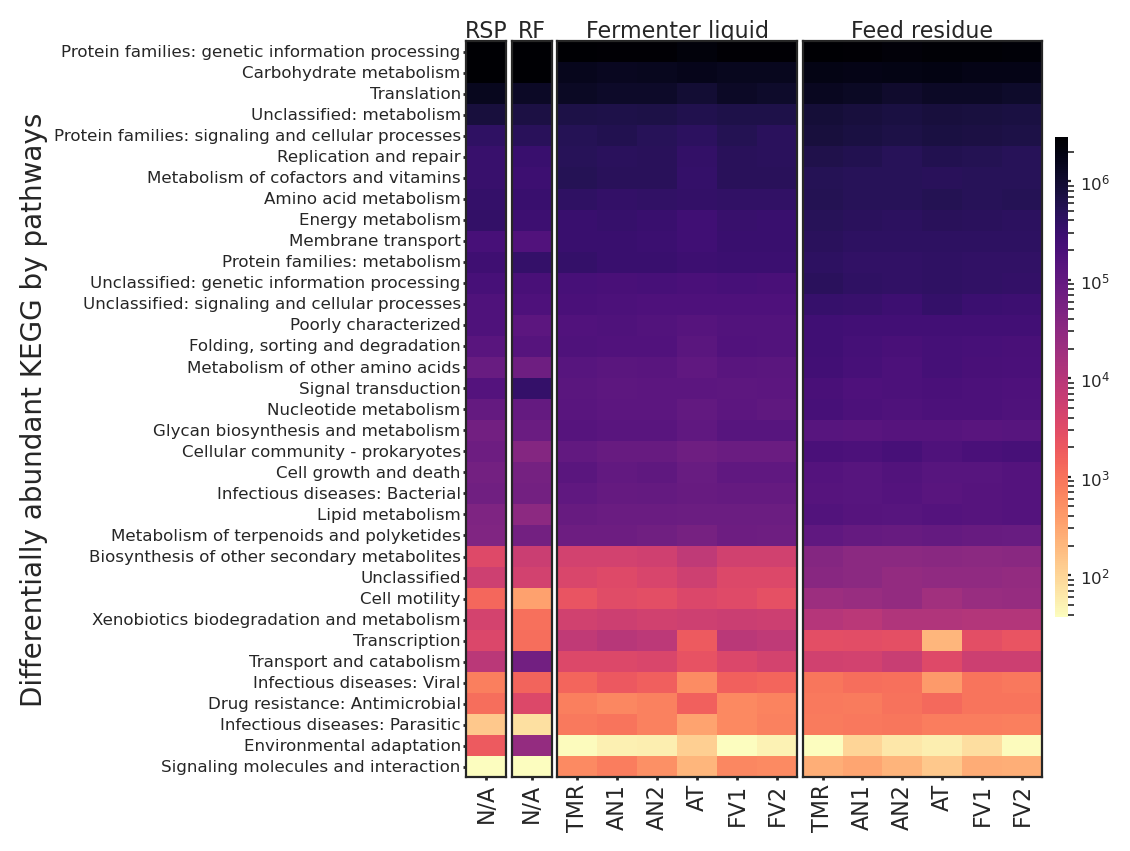

In [8]:
#import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from matplotlib.colors import LogNorm, Normalize
%matplotlib inline
plt.rcParams['axes.linewidth'] = .5 #adjust line width
plt.rcParams['figure.dpi'] = 200 #dpi in notebook
plt.rcParams['savefig.dpi'] = 600 #dpi in saved figure
sns.set_style("ticks") #set sns style

#metadata and data reading
keggs = pd.read_csv('Data/KEGG-names.tsv',sep='\t',index_col=0) #KEGG IDs, categories and letters
summary = pd.read_csv('Results/DESeq2/DESeq2.tsv',sep='\t',index_col=0) #DESeq2 summary
summ = summary.loc[(summary.Function=='KO')].copy() #only KEGGs
meta = pd.read_csv('metadata.tsv',sep='\t',index_col=0) #metadata
meta = meta.sort_values(['Treatment'],ascending=[True]) #sort metadata
meta['Sort'] = meta.rstc_run.astype(str)+'|'+meta.Treatment #create a col to sort groups
levs = ['Lev1','Lev2','Lev3']
gnames = {'RSP':'RSP','RF':'RF','FL':'Fermenter liquid','FR':'Feed residue'} #groups
names = {'Trt1':'TMR','Trt2':'AN1','Trt3':'AN2','Trt4':'AT','Trt5':'FV1','Trt6':'FV2','not_appl':'N/A'}
csort = ['TMR','AN1','AN2','AT','FV1','FV2'] #sort order
drop = ['Cancers: Specific types','Drug resistance: Antineoplastic','Nervous system','Immune system',
                'Endocrine and metabolic diseases','Cardiovascular diseases','Neurodegenerative diseases',
                'Excretory system','Cancers: Overview','Endocrine system','Digestive system'] #drop rows


#Separate all vs TMR and AT vs TMR subsets
for sub in ['All','AT']:
    if sub == 'All': continue
    sign = summ.loc[summ.padj<=0.05].copy() #only sign KEGGs (all)
    if sub == 'AT':
        sign = sign.loc[sign.Treatment=='Trt1-Trt4'].copy() #only sign KEGGs (AT)
 #Preparing data
    data = pd.DataFrame()
    for bs in gnames:
        df = pd.read_csv('Data/Tables_fn/KO-%s-norm_table.tsv'%(bs),sep='\t',index_col=0) #KO abund.
        df.index.names = ['Function']
        data = pd.concat([data,df],axis=1) #merge all tables
    data.fillna(0, inplace=True) #fill NaNs
    data = data.loc[sign.index.unique()] #only sign. KEGGs

 #collapse by levels
    data[levs] = keggs[levs] #add levels information
    data = data.groupby('Lev2').sum().copy()
    data = data.assign(m=data.mean(axis=1)).sort_values('m',ascending=False).drop('m',axis=1) #sort

 #Figure and corresponding variables
    vmax,vmin = data.values.max(), data.values.min() #max and min values to plot
    w = [len(meta.loc[meta.BS==g].Treatment.unique()) for g in gnames] # subbplot width
 #h = [len([k for k in keggs.loc[keggs.Lev1==x].Lev2.unique() if k in data.index]) for x in cats] # subbplot height
    fig, axes = plt.subplots(1,len(w),figsize=(3.2,4),\
                            gridspec_kw={'hspace':.02,'wspace':.04,'width_ratios':w,}) #figure 'height_ratios':h
 #axs,i = [[row,col] for row in range(len(h)) for col in range(len(w))],0 #axes
    cbar_ax = fig.add_axes([.92, .2, .02, .6]) #cbar ax
    cbar_ax.tick_params(labelsize=6,length=1)

    !mkdir -p Figures/Deseq2
 #for c in cats:
    for i,g in enumerate(gnames):
 #plot by axes
        md = meta.loc[meta.BS==g].copy() #metadata
        hm = data.loc[[l for l in data.index if l in keggs.Lev2.unique()],md.index].copy().T

 #collapse by treatment
        hm['Treatment'] = md.Treatment
        hm['Treatment'] = hm['Treatment'].map(names)
        hm = hm.groupby('Treatment').mean().T
        if 'TMR' in hm.columns: hm = hm[csort] #sort order
        hm = hm.drop(drop) # drop undesired columns

        ax = axes[i] #ax
 #ax, i = axes[axs[i][0]][axs[i][1]], i+1 #ax
        sns.heatmap(data=hm,ax=ax,xticklabels=True,yticklabels=True,cbar_ax=cbar_ax,
                                vmax=vmax,vmin=vmin,cmap='magma_r',robust=True,norm=LogNorm())
 #aesthetics
        ax.tick_params(axis='both',labelsize=6,length=1,pad=1,width=1)
        ax.tick_params(axis='x',labelsize=8,rotation=90)
        ax.set_ylabel('Differentially abundant KEGG by pathways',fontsize=10,labelpad=2)
        if g != list(gnames.keys())[0]:
            ax.axes.yaxis.set_visible(False)
            ax.set_ylabel('')
        ax.set_xlabel(gnames[g],fontsize=8,labelpad=2,)
        for _, spine in ax.spines.items(): 
            spine.set_visible(True)
            spine.set_linewidth(0.8)
        ax.get_xaxis().set_label_coords(.5,1.03)
 #fig.suptitle('Differentially abundant KEGGs by pathways', fontsize=9, y=.98)
    plt.subplots_adjust(left=0, bottom=0, right=.9, top=.92, wspace=0, hspace=0)
    plt.savefig('Figures/Deseq2/KEGG_Lev2_heatmap_%s.png'%sub, bbox_inches='tight',facecolor="w")

# CAZymes

## CAZy heatmap

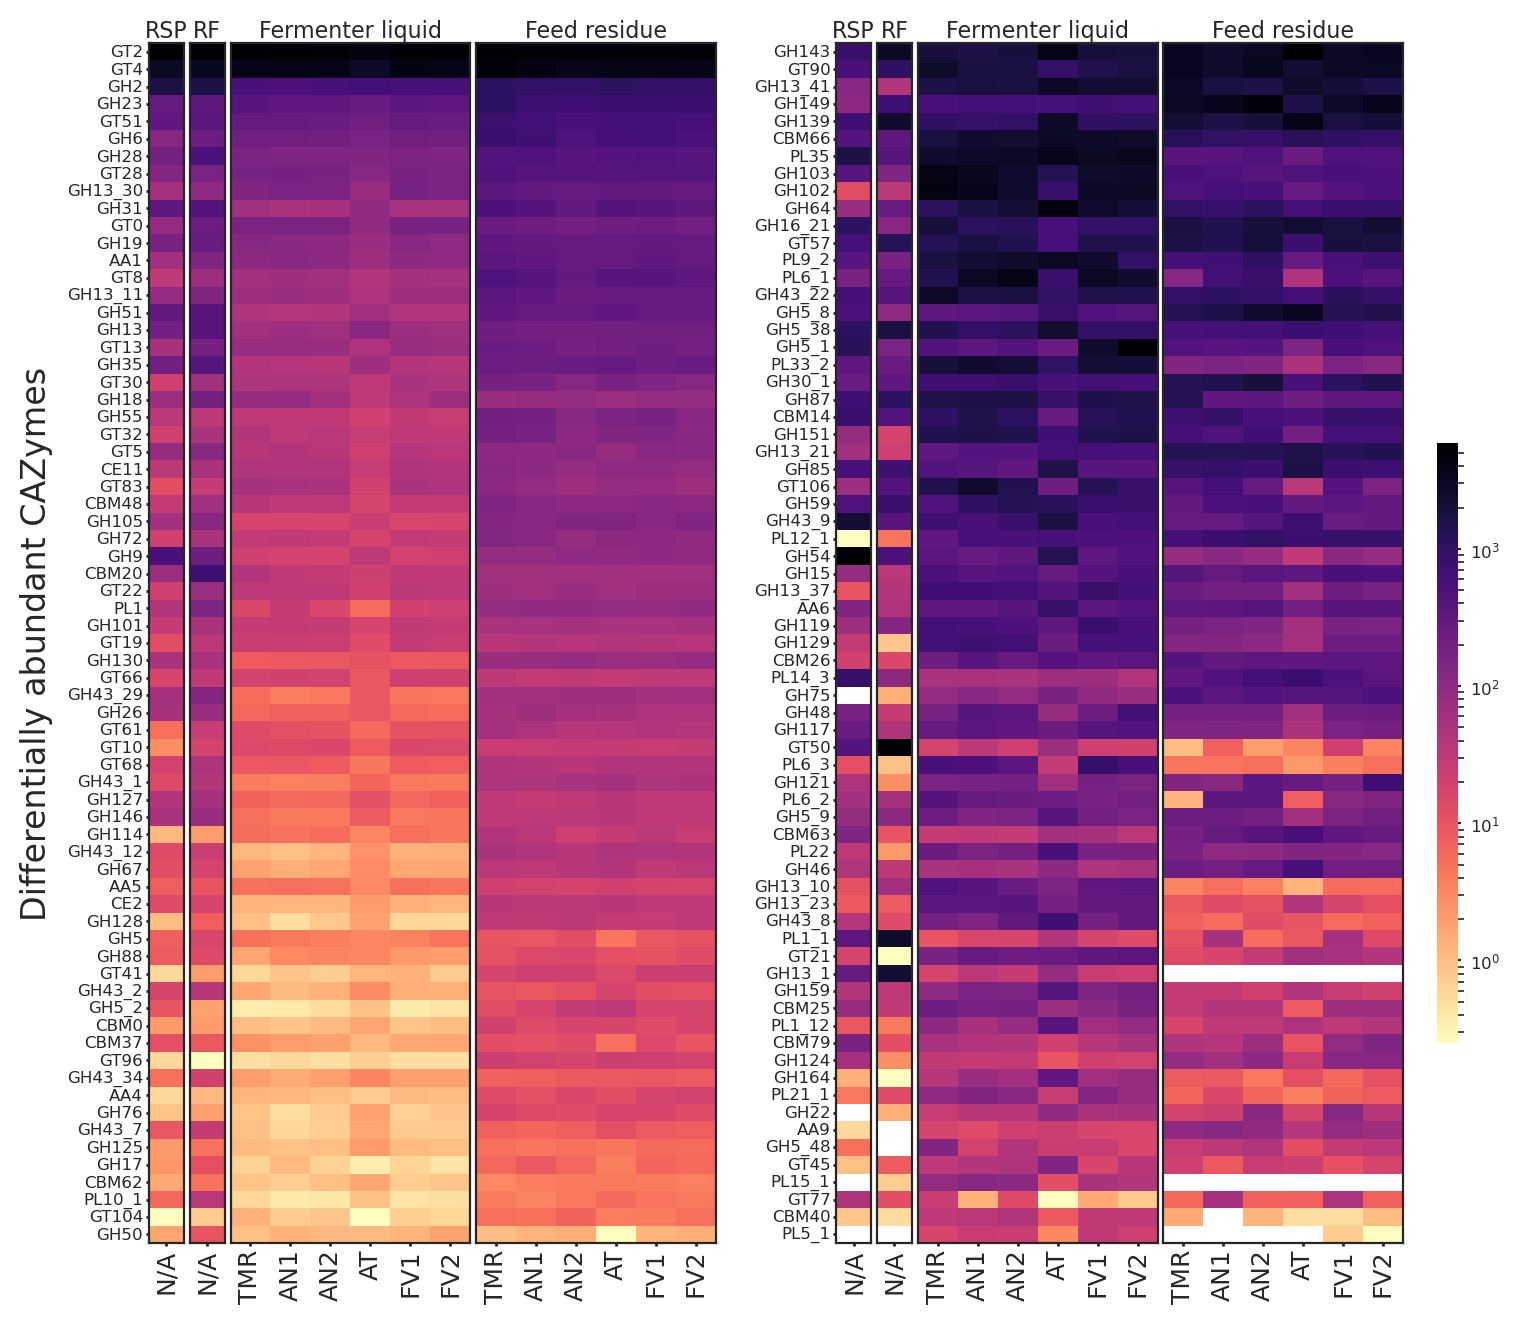

In [9]:
#import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from matplotlib.colors import LogNorm, Normalize
%matplotlib inline
plt.rcParams['axes.linewidth'] = .5 #adjust line width
plt.rcParams['figure.dpi'] = 200 #dpi in notebook
plt.rcParams['savefig.dpi'] = 600 #dpi in saved figure
sns.set_style("ticks") #set sns style
    
#metadata and data reading
cazy = pd.read_csv('Data/CAZy_activities.tsv',sep='\t',index_col=0) #CAZy avtivities
summary = pd.read_csv('Results/DESeq2/DESeq2.tsv',sep='\t',index_col=0) #DESeq2 summary
summ = summary.loc[(summary.Function=='CAZyDB')].copy() #only CAZymes
meta = pd.read_csv('metadata.tsv',sep='\t',index_col=0) #metadata
meta = meta.sort_values(['Treatment'],ascending=[True]) #sort metadata
meta['Sort'] = meta.rstc_run.astype(str)+'|'+meta.Treatment #create a col to sort groups
gnames = {'RSP':'RSP','RF':'RF','FL':'Fermenter liquid','FR':'Feed residue'} #groups
names = {'Trt1':'TMR','Trt2':'AN1','Trt3':'AN2','Trt4':'AT','Trt5':'FV1','Trt6':'FV2','not_appl':'N/A'}
csort = ['TMR','AN1','AN2','AT','FV1','FV2'] #sort order

#Separate all vs TMR and AT vs TMR subsets
for sub in ['All','AT']:
    if sub == 'All': continue
    sign = summ.loc[summ.padj<=0.05].copy() #only sign CAZy (all)
    if sub == 'AT':
        sign = sign.loc[sign.Treatment=='Trt1-Trt4'].copy() #only sign CAZy (AT)
 #Preparing data
    data = pd.DataFrame()
    for bs in gnames:
        df = pd.read_csv('Data/Tables_fn/CAZyDB-%s-norm_table.tsv'%(bs),sep='\t',index_col=0) #CAZy abund.
        df.index.names = ['Function']
        data = pd.concat([data,df],axis=1) #merge all tables
    data.fillna(0, inplace=True) #fill NaNs
    data = data.loc[sign.index.unique()] #only sign. CAZy
    data = data.assign(m=data.mean(axis=1)).sort_values('m',ascending=False).drop('m',axis=1) #sort

 #Figure and corresponding variables
    vmax,vmin = data.values.max(), data.values.min() #max and min values to plot
    w = [len(meta.loc[meta.BS==g].Treatment.unique()) for g in gnames] # subbplot width
    fig, axes = plt.subplots(1,2,figsize=(7,5),gridspec_kw={'wspace':.2,}) #figure
    cbar_ax = fig.add_axes([.92, .2, .015, .6]) #cbar ax
    cbar_ax.tick_params(labelsize=6,length=1)

    !mkdir -p Figures/Deseq2
    
    for j in range(2):
        bigax = axes[j] #outer ax
        bigax.axis('off')
        s = 0 # starting x for inner ax on bigax
        for i,g in enumerate(gnames):
            md = meta.loc[meta.BS==g].copy() #metadata
            hm = data[md.index].T

 #collapse by treatment
            hm['Treatment'] = md.Treatment
            hm['Treatment'] = hm['Treatment'].map(names)
            hm = hm.groupby('Treatment').mean().T
            hm = np.array_split(hm, 2)[j] #split df on 2
            if 'TMR' in hm.columns: hm = hm[csort] #sort order
            
 #creating inner axes
            width = w[i]/sum(w) # width for the inner ax
            ax = bigax.inset_axes([s,0,width-.01,1])
            s += width # update starting point

            sns.heatmap(data=hm,ax=ax,xticklabels=True,yticklabels=True,cbar_ax=cbar_ax,
                                    vmax=vmax,vmin=vmin,cmap='magma_r',robust=True,norm=LogNorm())
 #aesthetics
            ax.tick_params(axis='both',labelsize=6,length=1,pad=1,width=1)
            ax.tick_params(axis='x',labelsize=9,rotation=90)
            if j == 0: ax.set_ylabel('Differentially abundant CAZymes',fontsize=12,labelpad=5,)
            if g != list(gnames.keys())[0]:
                ax.yaxis.set_visible(False)
                ax.set_ylabel('')
            ax.set_xlabel(gnames[g],fontsize=8,labelpad=2,)
 #order = md.Sort
 #trts = [i for i in range(1,len(order)) if order[i].split('|')[1]!=order[i-1].split('|')[1]]
 #[ax.axvline(x=x,c='yellow',lw=.5,ls='--') for x in trts]
 #names = ['TMR','AN1','AN2','AT','FV1','FV2']
 #if g in ['FL','FR']: #add treatments
 #    [ax.text(j/len(names)+1/(2*len(names)),1.005,names[j],ha='center',fontsize=10,transform=ax.transAxes) \
 #     for j in range(len(names))]
            for _, spine in ax.spines.items(): 
                spine.set_visible(True)
                spine.set_linewidth(0.8)
            ax.get_xaxis().set_label_coords(.5,1.02)
 #fig.suptitle('Differentially abundant KEGGs', fontsize=9, y=.98)
    plt.subplots_adjust(left=0, bottom=0, right=.9, top=1.2, wspace=0, hspace=0)
    plt.savefig('Figures/Deseq2/CAZy_heatmap_%s.png'%sub, bbox_inches='tight',facecolor="w")

In [94]:
width

0.42857142857142855